
# Refactored Capstone Notebook

## What Changed
The core logic, features, and models remain the same, but the following improvements were made:

### Key Improvements
- All preprocessing moved into **ColumnTransformer + Pipeline**
- **SMOTE** applied *inside* pipelines (no data leakage)
- Consistent **Stratified Cross-Validation**
- Unified evaluation across models
- Entire pipelines saved for deployment




## 1. Imports



In [1]:
pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 413.9/413.9 kB 10.7 MB/s eta 0:00:00


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import optuna
import xgboost as xgb
import lightgbm as lgb
import joblib
import warnings
warnings.filterwarnings("ignore")

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, StandardScaler, FunctionTransformer
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, accuracy_score
from sklearn.feature_selection import mutual_info_classif, SelectKBest
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, ExtraTreesClassifier, StackingClassifier
from sklearn.svm import SVC
from scipy.stats import f_oneway,ttest_ind
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.impute import SimpleImputer
from imblearn.over_sampling import SMOTE



## 2. Data Loading



In [3]:
# Mount Google Drive to access files stored in my google Drive

from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [4]:

def load_data(train_path, test_path):
    """Load train and test datasets from given file paths."""
    train_df = pd.read_csv(train_path)
    test_df = pd.read_csv(test_path)
    return train_df, test_df

df_train, df_test = load_data('/content/drive/MyDrive/Capstone Project Data/train.csv',
                              '/content/drive/MyDrive/Capstone Project Data/test.csv')

# Display samples
print("Train Sample:")
display(df_train.head())
print("Test Sample:")
display(df_test.head())

# Display shapes
print(f"Train shape: {df_train.shape}")
print(f"Test shape: {df_test.shape}")


Train Sample:


,id,day,pressure,maxtemp,temparature,mintemp,dewpoint,humidity,cloud,sunshine,winddirection,windspeed,rainfall
0,0,1,1017.4,21.2,20.6,19.9,19.4,87.0,88.0,1.1,60.0,17.2,1
1,1,2,1019.5,16.2,16.9,15.8,15.4,95.0,91.0,0.0,50.0,21.9,1
2,2,3,1024.1,19.4,16.1,14.6,9.3,75.0,47.0,8.3,70.0,18.1,1
3,3,4,1013.4,18.1,17.8,16.9,16.8,95.0,95.0,0.0,60.0,35.6,1
4,4,5,1021.8,21.3,18.4,15.2,9.6,52.0,45.0,3.6,40.0,24.8,0


Test Sample:


,id,day,pressure,maxtemp,temparature,mintemp,dewpoint,humidity,cloud,sunshine,winddirection,windspeed
0,2190,1,1019.5,17.5,15.8,12.7,14.9,96.0,99.0,0.0,50.0,24.3
1,2191,2,1016.5,17.5,16.5,15.8,15.1,97.0,99.0,0.0,50.0,35.3
2,2192,3,1023.9,11.2,10.4,9.4,8.9,86.0,96.0,0.0,40.0,16.9
3,2193,4,1022.9,20.6,17.3,15.2,9.5,75.0,45.0,7.1,20.0,50.6
4,2194,5,1022.2,16.1,13.8,6.4,4.3,68.0,49.0,9.2,20.0,19.4


Train shape: (2190, 13)
Test shape: (730, 12)



## 3. Basic Info & Summary



In [5]:
# Check data types
print(df_train.info())

# Summary statistics
print(df_train.describe())

# Check for missing values
print(df_train.isnull().sum())
print(df_test.isnull().sum())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2190 entries, 0 to 2189
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             2190 non-null   int64  
 1   day            2190 non-null   int64  
 2   pressure       2190 non-null   float64
 3   maxtemp        2190 non-null   float64
 4   temparature    2190 non-null   float64
 5   mintemp        2190 non-null   float64
 6   dewpoint       2190 non-null   float64
 7   humidity       2190 non-null   float64
 8   cloud          2190 non-null   float64
 9   sunshine       2190 non-null   float64
 10  winddirection  2190 non-null   float64
 11  windspeed      2190 non-null   float64
 12  rainfall       2190 non-null   int64  
dtypes: float64(10), int64(3)
memory usage: 222.6 KB
None
                id          day     pressure      maxtemp  temparature  \
count  2190.000000  2190.000000  2190.000000  2190.000000  2190.000000   
mean   1094.500000   179.94

## 4.Target Variable Analysis

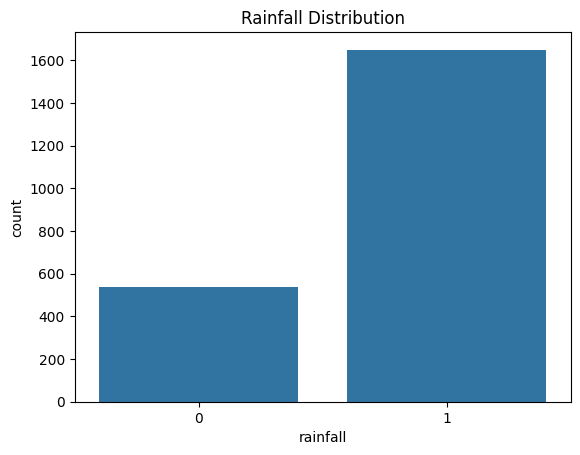

rainfall
1    0.753425
0    0.246575
Name: proportion, dtype: float64


In [6]:
# Visualize the distribution of the target variable 'rainfall'

sns.countplot(x='rainfall', data=df_train)
plt.title("Rainfall Distribution")
plt.show()

# Percentage of each class
print(df_train['rainfall'].value_counts(normalize=True))


In [7]:
# Identify all numeric features for analysis

num_cols = df_train.select_dtypes(include='number').columns.tolist()
num_cols.remove('rainfall')  # exclude target

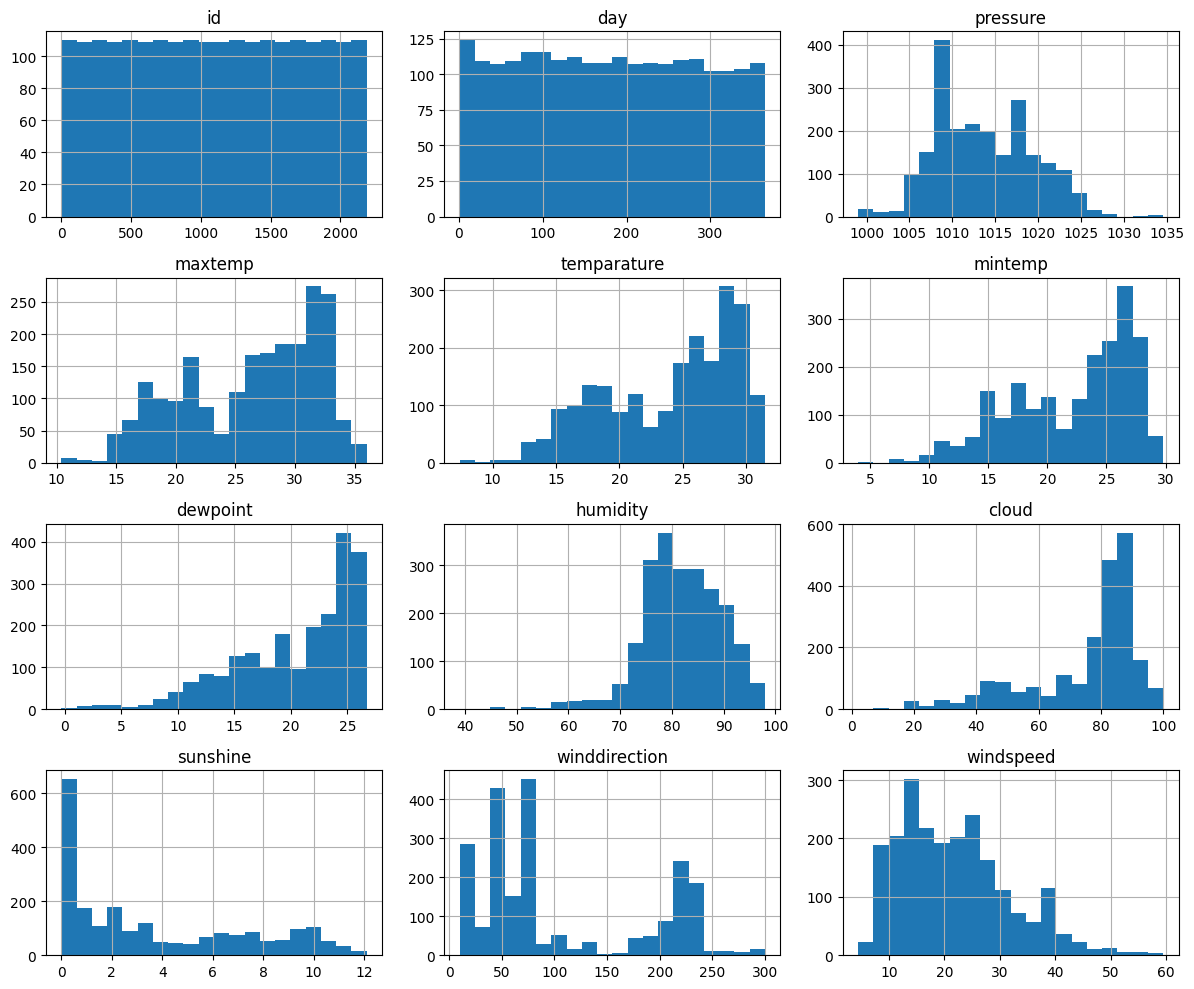

In [8]:
# Histograms
df_train[num_cols].hist(figsize=(12, 10), bins=20)
plt.tight_layout()
plt.show()

In [9]:
# Check skewness of numeric features
# Helps decide if transformations are needed (for linear/logistic models)
# Strongly skewed features: cloud, dewpoint (consider transforming if necessary)

df_train[num_cols].skew()


,0
id,0.000000
day,0.030615
pressure,0.284062
maxtemp,-0.490890
temparature,-0.557471
mintemp,-0.649179
dewpoint,-0.997889
humidity,-0.561541
cloud,-1.339274
sunshine,0.639871


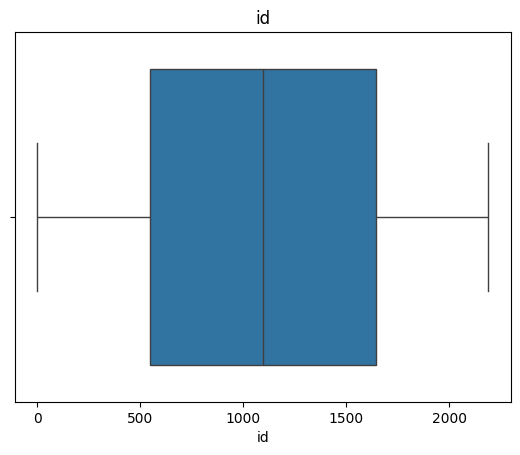

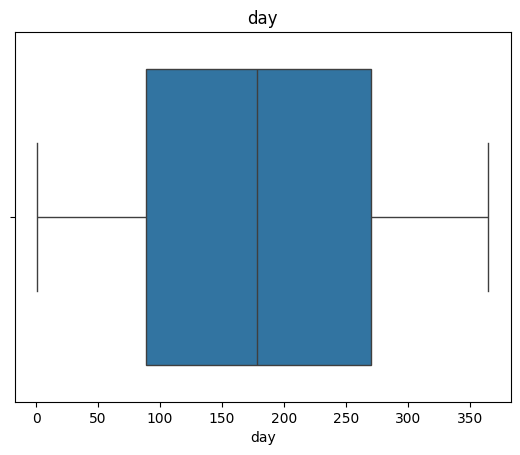

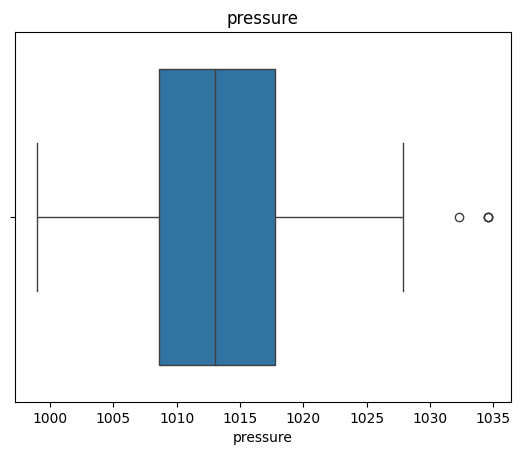

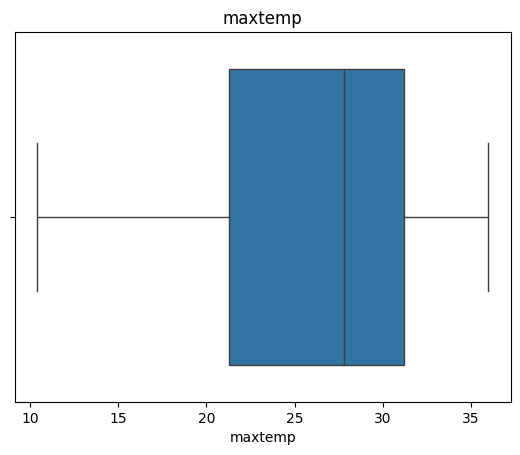

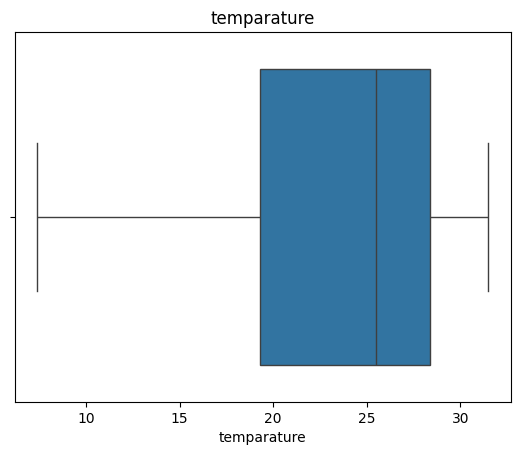

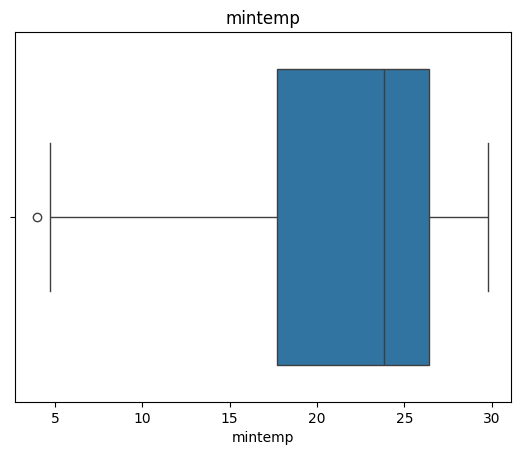

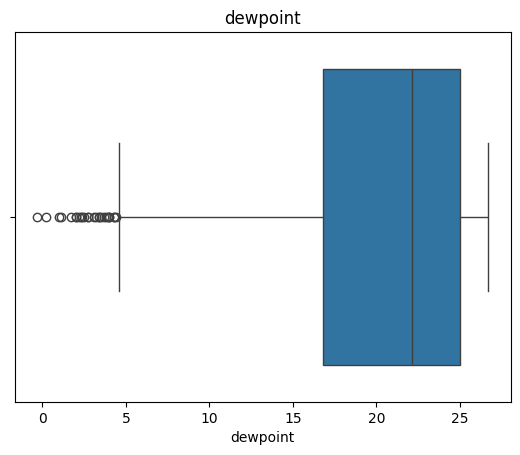

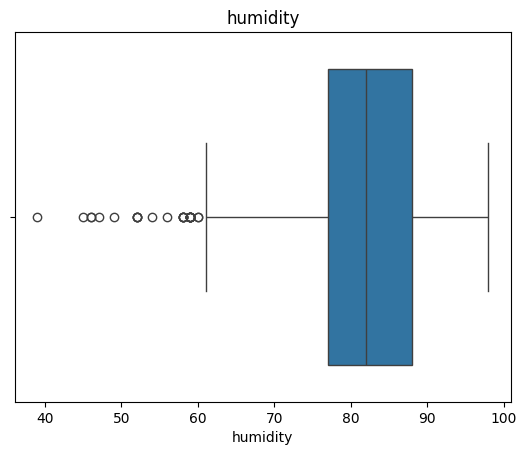

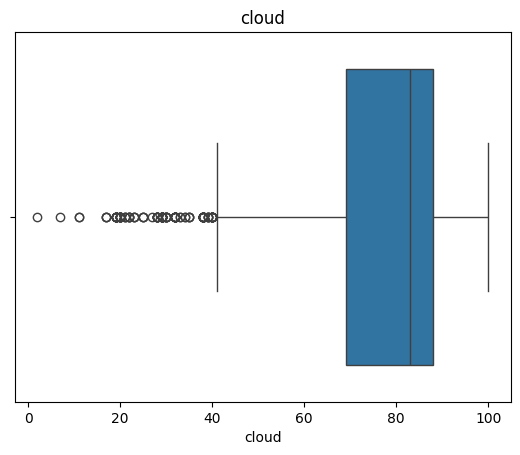

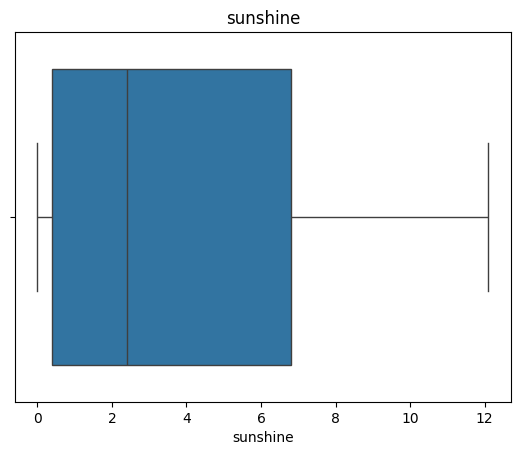

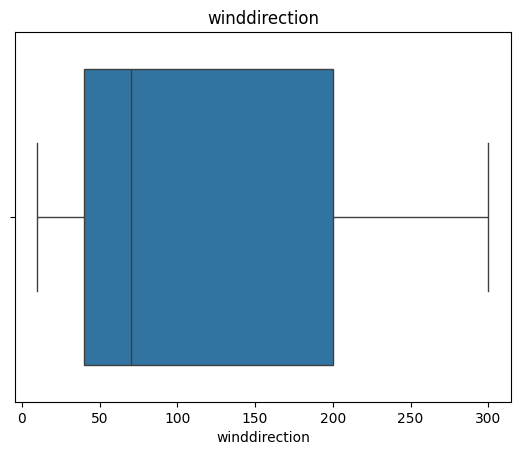

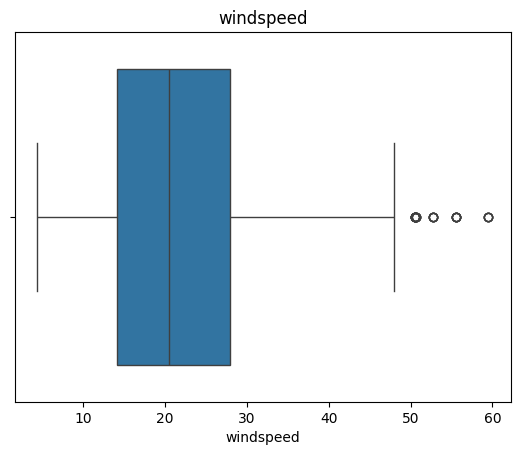

In [10]:
# Boxplots for outliers
for col in num_cols:
    sns.boxplot(x=df_train[col])
    plt.title(col)
    plt.show()

In [11]:
outlier_summary = []

for col in num_cols:
    Q1 = df_train[col].quantile(0.25)
    Q3 = df_train[col].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    outliers = df_train[(df_train[col] < lower) | (df_train[col] > upper)][col]
    outlier_summary.append({
        'Feature': col,
        'Num_Outliers': len(outliers),
        'Min_Outlier': outliers.min() if len(outliers) > 0 else None,
        'Max_Outlier': outliers.max() if len(outliers) > 0 else None
    })

outlier_df = pd.DataFrame(outlier_summary).sort_values(by='Num_Outliers', ascending=False)
display(outlier_df)


,Feature,Num_Outliers,Min_Outlier,Max_Outlier
8,cloud,129,2.0,40.0
7,humidity,28,39.0,60.0
11,windspeed,28,50.6,59.5
6,dewpoint,26,-0.3,4.4
2,pressure,4,1032.3,1034.6
5,mintemp,1,4.0,4.0
0,id,0,NaN,NaN
1,day,0,NaN,NaN
3,maxtemp,0,NaN,NaN
4,temparature,0,NaN,NaN


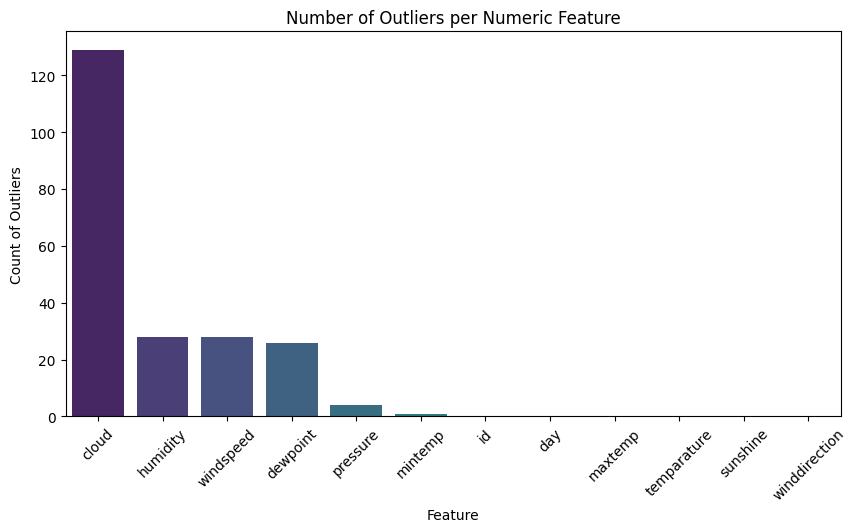

In [12]:
# Visualizizing columns with the most outliers

plt.figure(figsize=(10,5))
sns.barplot(data=outlier_df, x='Feature', y='Num_Outliers', palette='viridis')
plt.title("Number of Outliers per Numeric Feature")
plt.xticks(rotation=45)
plt.ylabel("Count of Outliers")
plt.show()


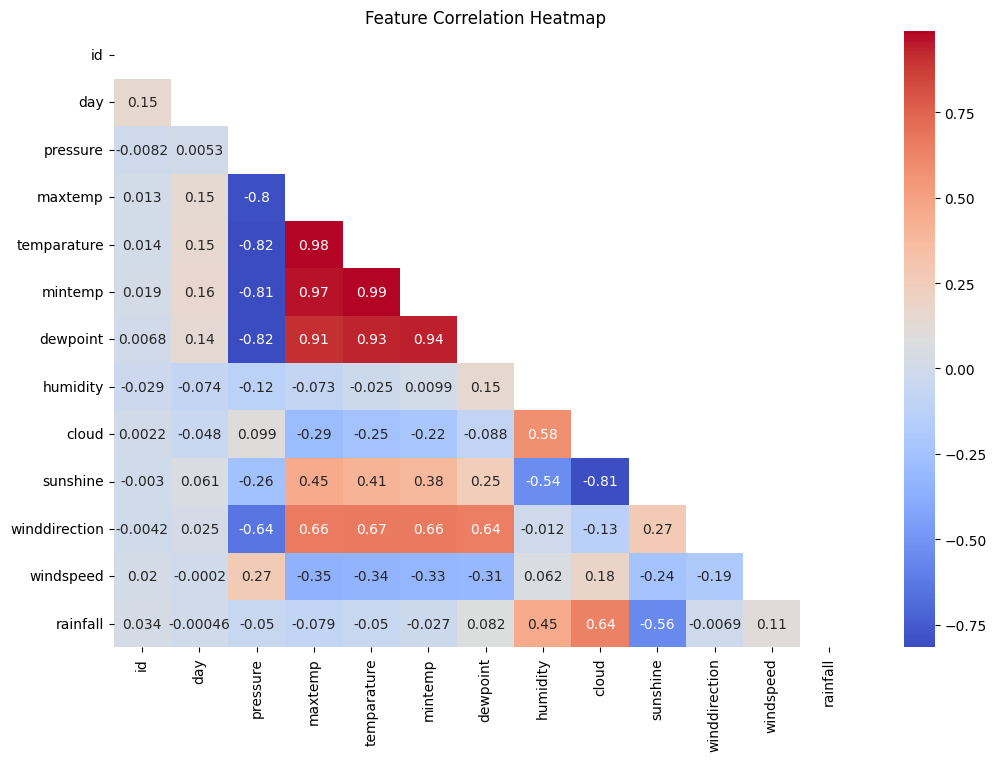

In [13]:
# Correlation heatmap

plt.figure(figsize=(12,8))
corr = df_train[num_cols + ['rainfall']].corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
sns.heatmap(corr, annot=True, cmap='coolwarm', mask=mask)
plt.title("Feature Correlation Heatmap")
plt.show()


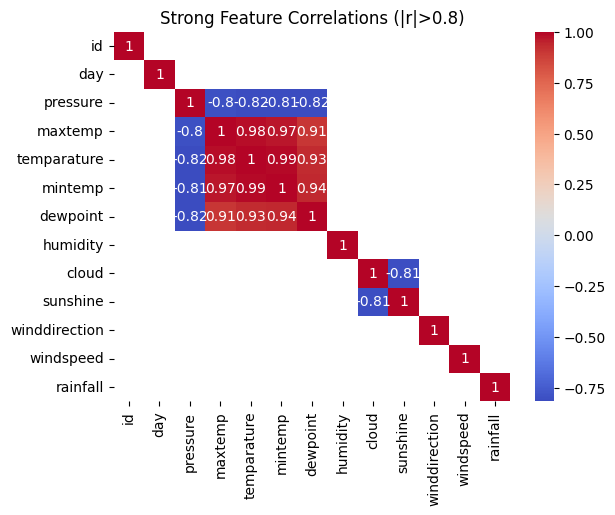

In [14]:
# Highlighting Strong correlations

strong_corr = corr.abs() > 0.8
sns.heatmap(corr, annot=True, cmap='coolwarm', mask=~strong_corr)
plt.title("Strong Feature Correlations (|r|>0.8)")
plt.show()


In [15]:
cat_cols = df_train.select_dtypes(include='object').columns.tolist()

for col in cat_cols:
    sns.countplot(y=col, data=df_train, order=df_train[col].value_counts().index)
    plt.title(f"{col} Distribution")
    plt.show()


## 5.Feature Relationships with Target

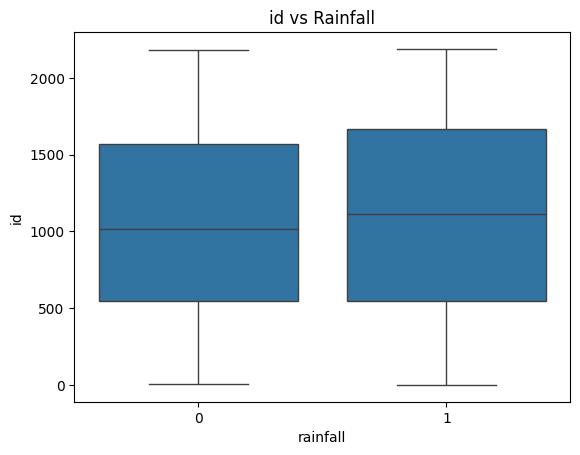

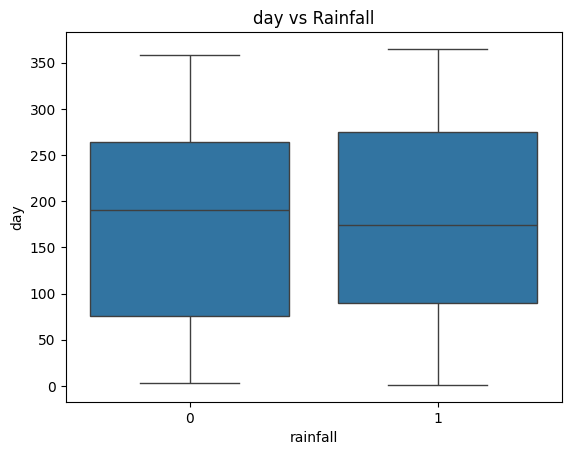

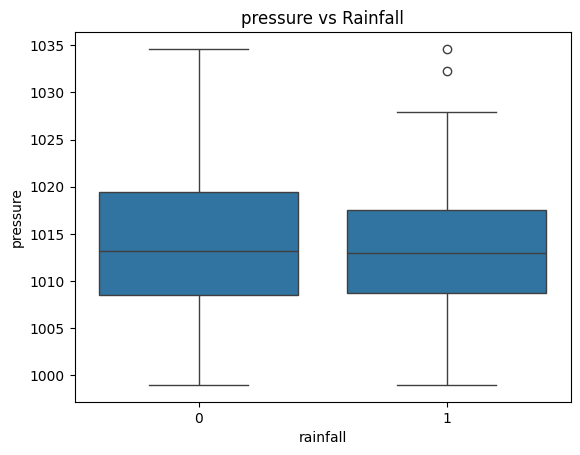

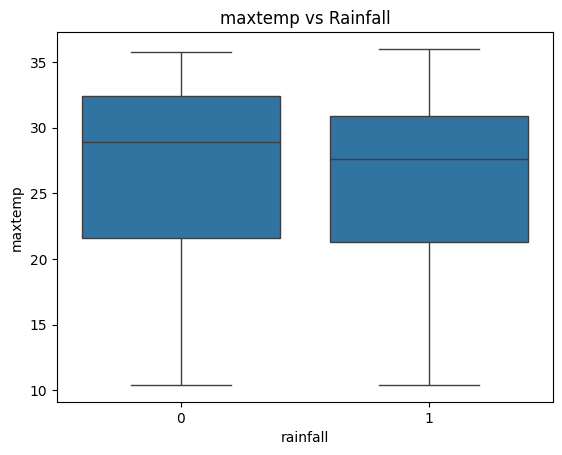

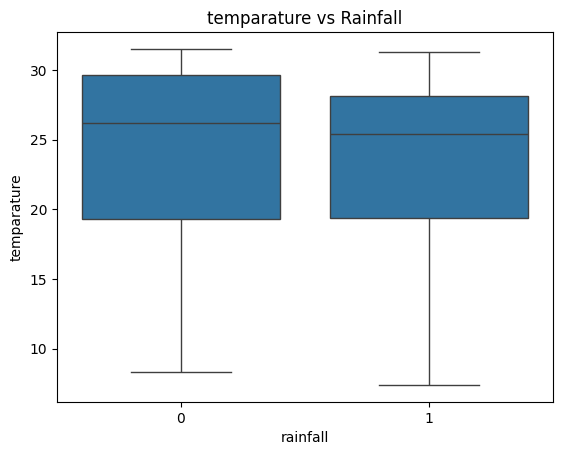

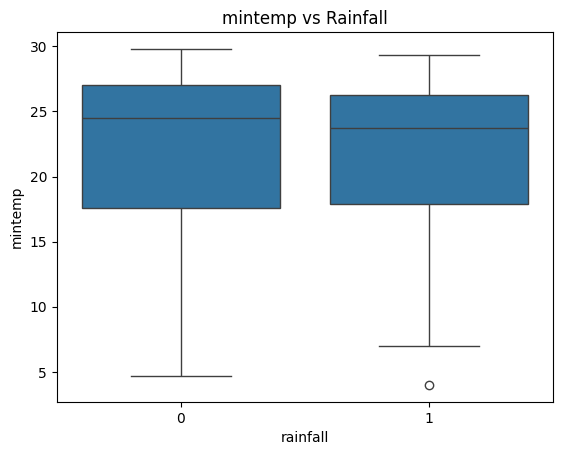

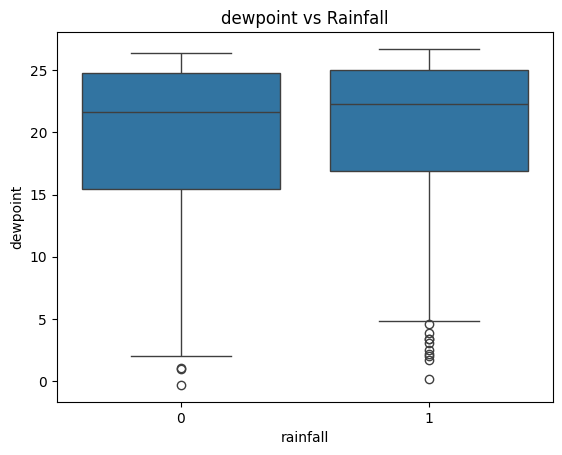

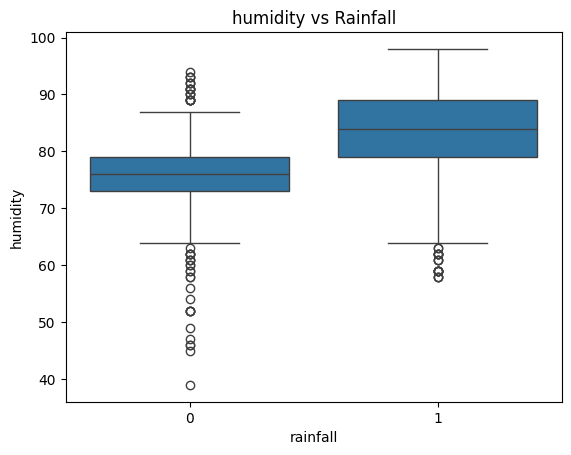

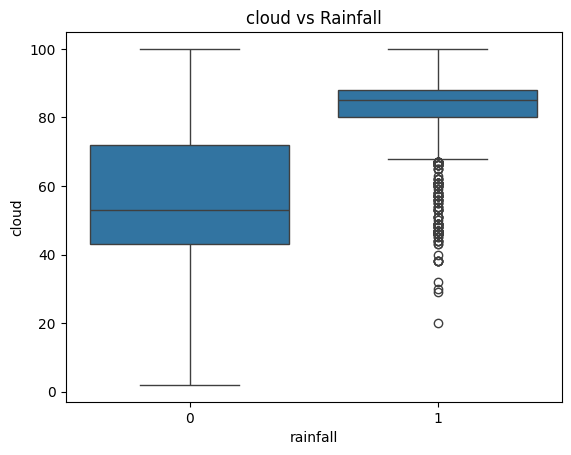

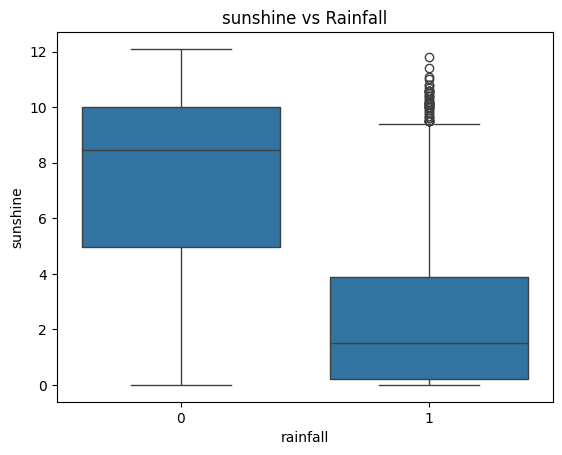

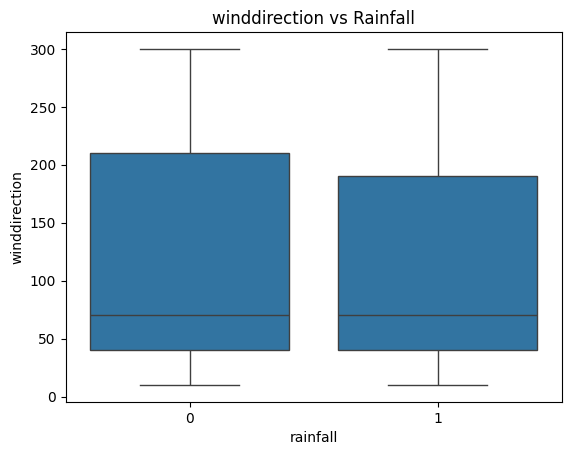

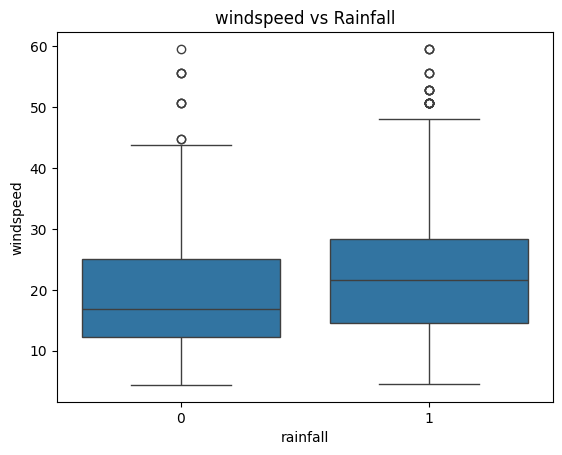

In [16]:
# Numerical vs Target
for col in num_cols:
    sns.boxplot(x='rainfall', y=col, data=df_train)
    plt.title(f"{col} vs Rainfall")
    plt.show()

In [17]:
# Categorical vs Target
for col in cat_cols:
    sns.countplot(x=col, hue='rainfall', data=df_train)
    plt.title(f"{col} vs Rainfall")
    plt.show()

In [18]:
def day_to_month(day):
    if day <= 31: return 1
    elif day <= 59: return 2
    elif day <= 90: return 3
    elif day <= 120: return 4
    elif day <= 151: return 5
    elif day <= 181: return 6
    elif day <= 212: return 7
    elif day <= 243: return 8
    elif day <= 273: return 9
    elif day <= 304: return 10
    elif day <= 334: return 11
    else: return 12

df_train["month"] = df_train["day"].apply(day_to_month)



In [19]:
monthly_rainfall = df_train.groupby("month")["rainfall"].mean()



In [20]:
import calendar
monthly_rainfall.index = monthly_rainfall.index.map(lambda x: calendar.month_abbr[x])


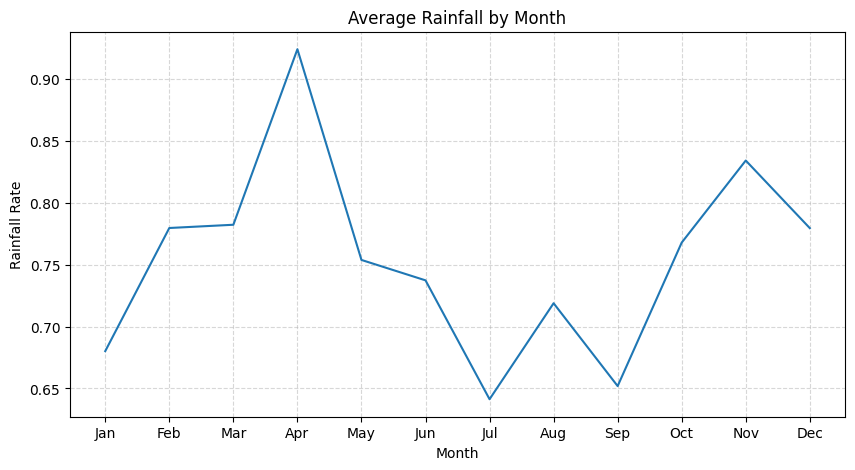

In [21]:
plt.figure(figsize=(10,5))
plt.plot(monthly_rainfall.index, monthly_rainfall.values)
plt.grid(True, linestyle='--', alpha=0.5)
plt.xlabel("Month")
plt.ylabel("Rainfall Rate")
plt.title("Average Rainfall by Month")
plt.show()


### Outcome: After this EDA, you’ll know:

Which features are useful or need transformation

If target is imbalanced

Outliers or missing values to handle

Relationships that could inspire new features

## 6.Train-Test Split

In [22]:
# Dropping 'id' column as it has not predictive value

X = df_train.drop(columns=["id", "rainfall"])
y = df_train["rainfall"]

print(X.columns)
print(X.shape)


Index(['day', 'pressure', 'maxtemp', 'temparature', 'mintemp', 'dewpoint',
       'humidity', 'cloud', 'sunshine', 'winddirection', 'windspeed', 'month'],
      dtype='object')
(2190, 12)


In [23]:

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42,stratify=y   # preserves class distribution
)

# Performing a sanity check

print("Train distribution:")
print(y_train.value_counts(normalize=True))

print("\nValidation distribution:")
print(y_val.value_counts(normalize=True))


Train distribution:
rainfall
1    0.753425
0    0.246575
Name: proportion, dtype: float64

Validation distribution:
rainfall
1    0.753425
0    0.246575
Name: proportion, dtype: float64


In [24]:
for df in [X_train, X_val]:
    if "temparature" in df.columns:
        df.rename(columns={"temparature": "temperature"}, inplace=True)

## 7. Column Transformation/Preprocessing Pipline

In [25]:

# Step 1: Feature Engineering

class FeatureEngineer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        # Learn the median for winddirection to avoid leakage
        if "winddirection" in X.columns:
            self.winddirection_median_ = X["winddirection"].median()
        return self

    def transform(self, X):
        X = X.copy()

        # 1️⃣ Fill missing winddirection values with median from training set
        if "winddirection" in X.columns:
            X["winddirection"] = X["winddirection"].fillna(self.winddirection_median_)

        # 2️⃣ Windspeed category using quantiles (Low, Medium, High)
        if "windspeed" in X.columns:
            X["windspeed_category"] = pd.qcut(
                X["windspeed"],
                q=3,  # splits data into 3 equal-sized bins
                labels=["Low", "Medium", "High"]
            )

        # 3️⃣ Temperature range
        if {"maxtemp", "mintemp"}.issubset(X.columns):
            X["temp_range"] = X["maxtemp"] - X["mintemp"]

        # 4️⃣ Cyclical day encoding
        if "day" in X.columns:
            X["day_sin"] = np.sin(2 * np.pi * X["day"] / 365)
            X["day_cos"] = np.cos(2 * np.pi * X["day"] / 365)
            X.drop(columns=["day"], inplace=True)

        return X


In [26]:

# Step 2: Correlation Filter (numeric only)

class CorrelationFilter(BaseEstimator, TransformerMixin):
    def __init__(self, threshold=0.9, keep_columns=None):
        self.threshold = threshold
        self.keep_columns = keep_columns
        self.to_drop_ = None

    def fit(self, X, y=None):
        X = pd.DataFrame(X)
        numeric_columns = X.select_dtypes(include=[np.number]).columns
        corr_matrix = X[numeric_columns].corr().abs()
        upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
        self.to_drop_ = [col for col in upper.columns if any(upper[col] > self.threshold)]
        if self.keep_columns:
            self.to_drop_ = [c for c in self.to_drop_ if c not in self.keep_columns]
        return self

    def transform(self, X):
        X = pd.DataFrame(X).copy()
        return X.drop(columns=self.to_drop_, errors="ignore")


In [27]:

# Step 3: Column Transformer (joblib-safe)

numeric_features = [
    "windspeed", "temperature", "maxtemp", "mintemp",
    "humidity", "pressure", "dewpoint", "cloud", "sunshine",
    "temp_range", "day_sin", "day_cos"
]

categorical_features = [
    "windspeed_category", "winddirection"
]

# Named function for Inf → NaN (joblib-safe)
def inf_to_nan_func(X):
    return np.where(np.isinf(X), np.nan, X)

inf_to_nan = FunctionTransformer(inf_to_nan_func, feature_names_out="one-to-one")

numeric_transformer = Pipeline([
    ("inf_to_nan", inf_to_nan),
    ("imputer", SimpleImputer(strategy="median"))
])

categorical_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("encoder", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
])

preprocessor = ColumnTransformer([
    ("num", numeric_transformer, numeric_features),
    ("cat", categorical_transformer, categorical_features)
], remainder="drop")


## 8. Pipeline Construction

In [28]:

# Step 4: Full Pipeline (preprocessing + MI selection)

preprocessing_mi_pipeline = Pipeline([
    ("feature_engineering", FeatureEngineer()),
    ("correlation_filter", CorrelationFilter(threshold=0.9, keep_columns=numeric_features)),
    ("preprocessing", preprocessor),# joblib-safe now
    ("mi_selection", SelectKBest(score_func=mutual_info_classif, k=20))
])

## 9. Model Training, Hyperparameter Tuning & Model evalauation

In [29]:

# Step 5: Transform

X_train_transformed = preprocessing_mi_pipeline.fit_transform(X_train, y_train)
X_val_transformed = preprocessing_mi_pipeline.transform(X_val)

In [30]:
# Get ALL feature names from ColumnTransformer

column_transformer = preprocessing_mi_pipeline.named_steps["preprocessing"]
all_feature_names = column_transformer.get_feature_names_out()

# Apply MI selector mask

mi_selector = preprocessing_mi_pipeline.named_steps["mi_selection"]
selected_mask = mi_selector.get_support()

selected_feature_names = all_feature_names[selected_mask]

print(f"Total features after MI selection: {len(selected_feature_names)}")


Total features after MI selection: 20


[I 2026-02-14 09:26:59,748] A new study created in memory with name: no-name-295e598a-a4ac-4a4f-b991-300e4bc96325
[I 2026-02-14 09:27:01,379] Trial 0 finished with value: 0.8879735607883162 and parameters: {'n_estimators': 139, 'max_depth': 4, 'min_samples_split': 6, 'min_samples_leaf': 3}. Best is trial 0 with value: 0.8879735607883162.
[I 2026-02-14 09:27:02,621] Trial 1 finished with value: 0.8881314143844217 and parameters: {'n_estimators': 91, 'max_depth': 8, 'min_samples_split': 14, 'min_samples_leaf': 5}. Best is trial 1 with value: 0.8881314143844217.
[I 2026-02-14 09:27:03,746] Trial 2 finished with value: 0.8872800782484023 and parameters: {'n_estimators': 94, 'max_depth': 4, 'min_samples_split': 10, 'min_samples_leaf': 10}. Best is trial 1 with value: 0.8881314143844217.
[I 2026-02-14 09:27:05,193] Trial 3 finished with value: 0.8897592606093008 and parameters: {'n_estimators': 110, 'max_depth': 10, 'min_samples_split': 11, 'min_samples_leaf': 8}. Best is trial 3 with value:


Best hyperparameters for each model:
RandomForest: {'n_estimators': 281, 'max_depth': 7, 'min_samples_split': 20, 'min_samples_leaf': 4}
GradientBoosting: {'n_estimators': 273, 'learning_rate': 0.011782613983568804, 'max_depth': 2, 'min_samples_split': 13, 'min_samples_leaf': 4}
AdaBoost: {'n_estimators': 138, 'learning_rate': 0.18265124489785745}
ExtraTrees: {'n_estimators': 238, 'max_depth': 11, 'min_samples_split': 10, 'min_samples_leaf': 7}
LogisticRegression: {'C': 4.308661382633495, 'penalty': 'l1'}

==== RandomForest ====
Accuracy: 0.8767
ROC AUC: 0.8796
Classification Report:
               precision    recall  f1-score   support

           0       0.81      0.65      0.72       108
           1       0.89      0.95      0.92       330

    accuracy                           0.88       438
   macro avg       0.85      0.80      0.82       438
weighted avg       0.87      0.88      0.87       438



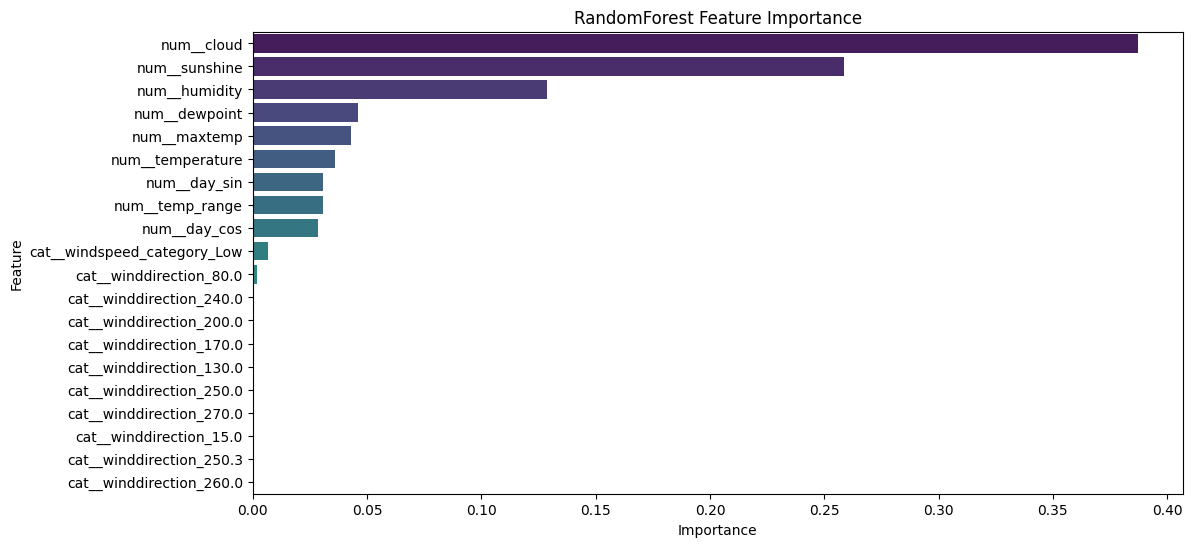


==== GradientBoosting ====
Accuracy: 0.8699
ROC AUC: 0.8753
Classification Report:
               precision    recall  f1-score   support

           0       0.81      0.62      0.70       108
           1       0.88      0.95      0.92       330

    accuracy                           0.87       438
   macro avg       0.85      0.79      0.81       438
weighted avg       0.87      0.87      0.86       438



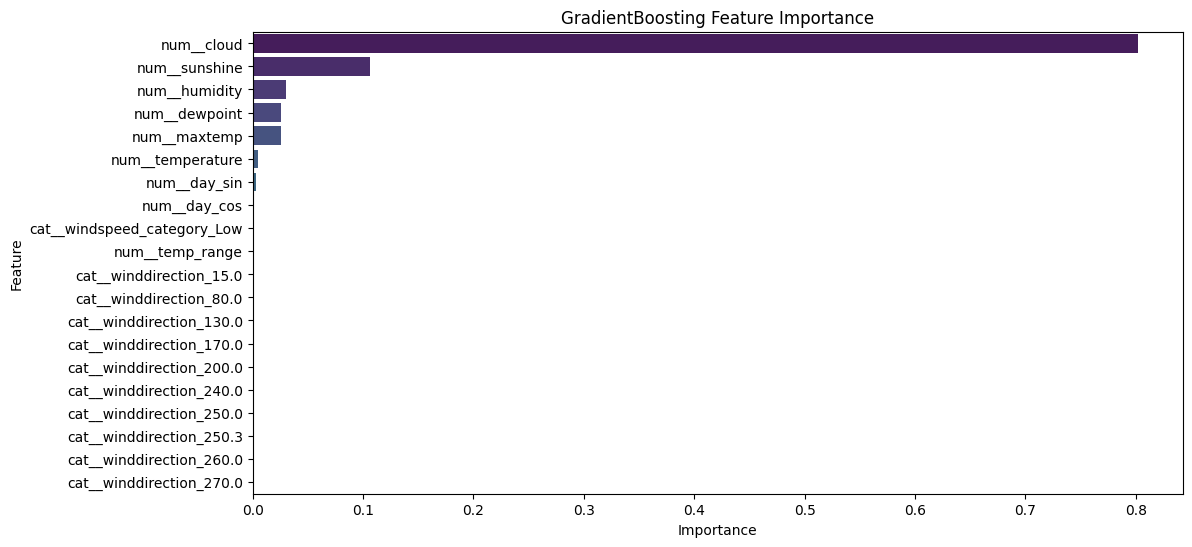


==== AdaBoost ====
Accuracy: 0.8676
ROC AUC: 0.8774
Classification Report:
               precision    recall  f1-score   support

           0       0.77      0.67      0.71       108
           1       0.90      0.93      0.91       330

    accuracy                           0.87       438
   macro avg       0.83      0.80      0.81       438
weighted avg       0.86      0.87      0.86       438



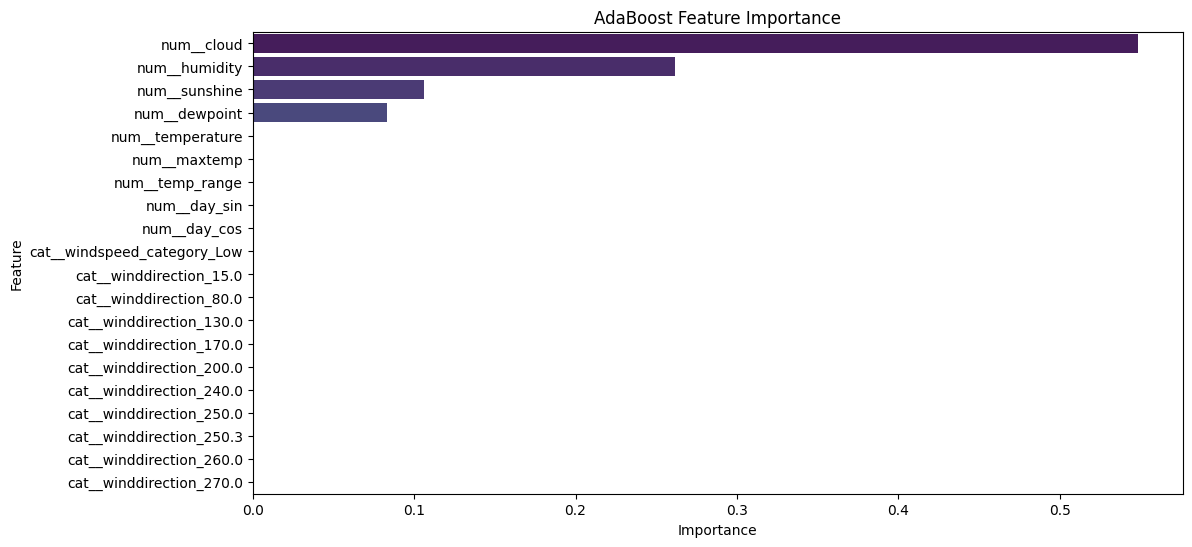


==== ExtraTrees ====
Accuracy: 0.8653
ROC AUC: 0.8789
Classification Report:
               precision    recall  f1-score   support

           0       0.81      0.59      0.68       108
           1       0.88      0.95      0.91       330

    accuracy                           0.87       438
   macro avg       0.84      0.77      0.80       438
weighted avg       0.86      0.87      0.86       438



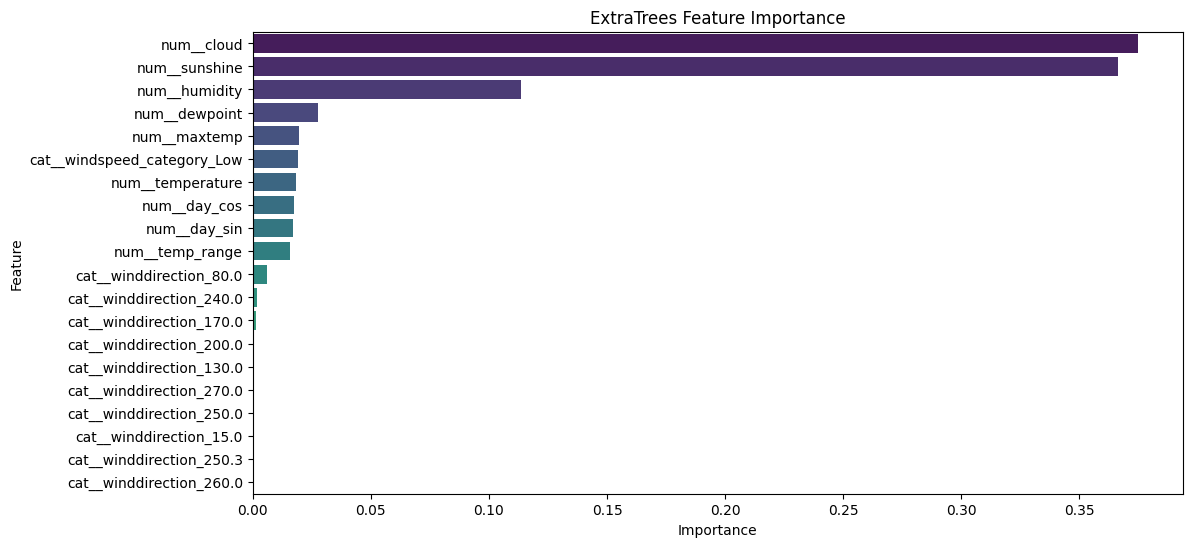


==== LogisticRegression ====
Accuracy: 0.8630
ROC AUC: 0.8678
Classification Report:
               precision    recall  f1-score   support

           0       0.78      0.62      0.69       108
           1       0.88      0.94      0.91       330

    accuracy                           0.86       438
   macro avg       0.83      0.78      0.80       438
weighted avg       0.86      0.86      0.86       438



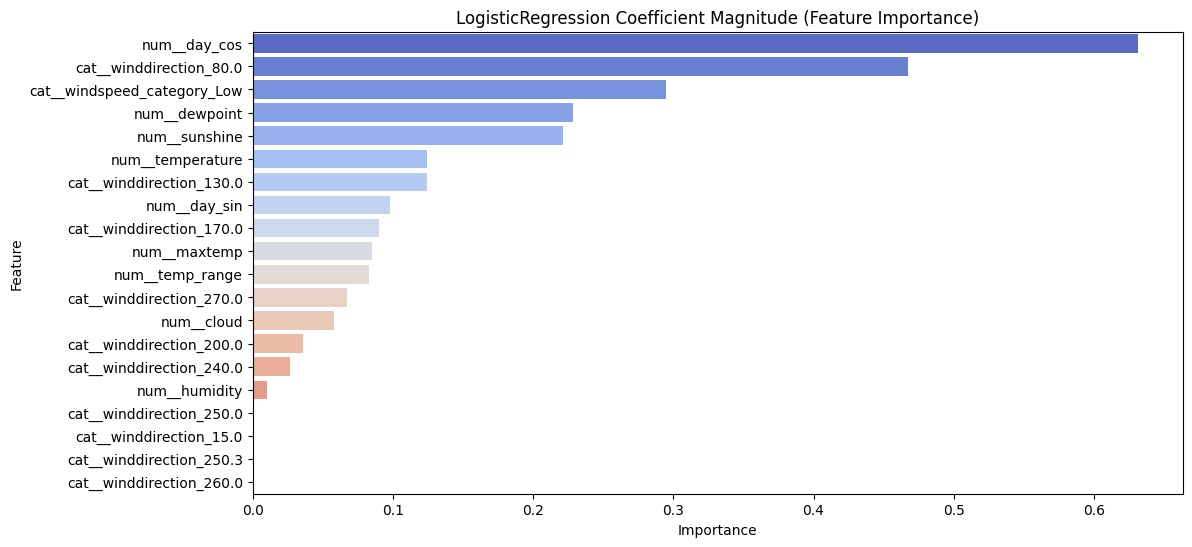

In [31]:

# 1 Define Optuna objective functions for hyperparameter tuning

def rf_objective(trial):
    model = RandomForestClassifier(
        n_estimators=trial.suggest_int("n_estimators", 50, 300),
        max_depth=trial.suggest_int("max_depth", 3, 20),
        min_samples_split=trial.suggest_int("min_samples_split", 2, 20),
        min_samples_leaf=trial.suggest_int("min_samples_leaf", 1, 10),
        random_state=42,
        n_jobs=-1
    )
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    return cross_val_score(model, X_train_transformed, y_train, cv=cv, scoring="roc_auc").mean()

def gb_objective(trial):
    model = GradientBoostingClassifier(
        n_estimators=trial.suggest_int("n_estimators", 50, 300),
        learning_rate=trial.suggest_float("learning_rate", 0.01, 0.3),
        max_depth=trial.suggest_int("max_depth", 2, 10),
        min_samples_split=trial.suggest_int("min_samples_split", 2, 20),
        min_samples_leaf=trial.suggest_int("min_samples_leaf", 1, 10),
        random_state=42
    )
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    return cross_val_score(model, X_train_transformed, y_train, cv=cv, scoring="roc_auc").mean()

def ada_objective(trial):
    model = AdaBoostClassifier(
        n_estimators=trial.suggest_int("n_estimators", 50, 300),
        learning_rate=trial.suggest_float("learning_rate", 0.01, 2.0),
        random_state=42
    )
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    return cross_val_score(model, X_train_transformed, y_train, cv=cv, scoring="roc_auc").mean()

def et_objective(trial):
    model = ExtraTreesClassifier(
        n_estimators=trial.suggest_int("n_estimators", 50, 300),
        max_depth=trial.suggest_int("max_depth", 3, 20),
        min_samples_split=trial.suggest_int("min_samples_split", 2, 20),
        min_samples_leaf=trial.suggest_int("min_samples_leaf", 1, 10),
        random_state=42,
        n_jobs=-1
    )
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    return cross_val_score(model, X_train_transformed, y_train, cv=cv, scoring="roc_auc").mean()

def lr_objective(trial):
    C = trial.suggest_loguniform("C", 1e-3, 1e3)
    penalty = trial.suggest_categorical("penalty", ["l1", "l2"])
    solver = "saga"  # ✅ saga supports both l1 and l2
    model = LogisticRegression(
        C=C, penalty=penalty, solver=solver, max_iter=2000, random_state=42
    )
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    return cross_val_score(model, X_train_transformed, y_train, cv=cv, scoring="roc_auc").mean()

# 2️. Tune models with Optuna

def tune_model(objective_fn, n_trials=30):
    study = optuna.create_study(direction="maximize")
    study.optimize(objective_fn, n_trials=n_trials)
    return study.best_trial.params

best_params = {}
best_params["RandomForest"] = tune_model(rf_objective)
best_params["GradientBoosting"] = tune_model(gb_objective)
best_params["AdaBoost"] = tune_model(ada_objective)
best_params["ExtraTrees"] = tune_model(et_objective)
best_params["LogisticRegression"] = tune_model(lr_objective)

print("\nBest hyperparameters for each model:")
for name, params in best_params.items():
    print(f"{name}: {params}")


# 3️. Train final tuned models and evaluate

models = {
    "RandomForest": RandomForestClassifier(**best_params["RandomForest"], random_state=42, n_jobs=-1),
    "GradientBoosting": GradientBoostingClassifier(**best_params["GradientBoosting"], random_state=42),
    "AdaBoost": AdaBoostClassifier(**best_params["AdaBoost"], random_state=42),
    "ExtraTrees": ExtraTreesClassifier(**best_params["ExtraTrees"], random_state=42, n_jobs=-1),
    "LogisticRegression": LogisticRegression(**best_params["LogisticRegression"], max_iter=2000, solver="saga", random_state=42)
}

for name, model in models.items():
    print(f"\n==== {name} ====")
    model.fit(X_train_transformed, y_train)
    y_pred = model.predict(X_val_transformed)
    y_pred_proba = model.predict_proba(X_val_transformed)[:,1] if hasattr(model, "predict_proba") else None

    accuracy = accuracy_score(y_val, y_pred)
    roc_auc = roc_auc_score(y_val, y_pred_proba) if y_pred_proba is not None else None
    report = classification_report(y_val, y_pred)

    print(f"Accuracy: {accuracy:.4f}")
    if roc_auc is not None:
        print(f"ROC AUC: {roc_auc:.4f}")
    print("Classification Report:\n", report)

    # Feature importance
    if hasattr(model, "feature_importances_"):
        fi = pd.DataFrame({
            "Feature": selected_feature_names,
            "Importance": model.feature_importances_
        }).sort_values(by="Importance", ascending=False)
        plt.figure(figsize=(12,6))
        sns.barplot(x="Importance", y="Feature", data=fi, palette="viridis")
        plt.title(f"{name} Feature Importance")
        plt.show()
    elif hasattr(model, "coef_"):
        coefs = abs(model.coef_).flatten()
        fi = pd.DataFrame({
            "Feature": selected_feature_names,
            "Importance": coefs
        }).sort_values(by="Importance", ascending=False)
        plt.figure(figsize=(12,6))
        sns.barplot(x="Importance", y="Feature", data=fi, palette="coolwarm")
        plt.title(f"{name} Coefficient Magnitude (Feature Importance)")
        plt.show()


In [32]:

# STEP 4: Compare all models & select best

results = []
trained_models = {}

for name, model in models.items():
    # store trained model
    trained_models[name] = model

    # predictions
    y_pred = model.predict(X_val_transformed)
    if hasattr(model, "predict_proba"):
        y_pred_proba = model.predict_proba(X_val_transformed)[:, 1]
        roc_auc = roc_auc_score(y_val, y_pred_proba)
    else:
        roc_auc = None
    accuracy = accuracy_score(y_val, y_pred)

    # append results
    results.append({
        "Model": name,
        "Accuracy": accuracy,
        "ROC_AUC": roc_auc
    })

# Convert to DataFrame
results_df = pd.DataFrame(results).sort_values(by="ROC_AUC", ascending=False).reset_index(drop=True)
display(results_df)

# Select best model
best_model_name = results_df.loc[0, "Model"]
best_model = trained_models[best_model_name]
print(f"Best model selected: {best_model_name}")


,Model,Accuracy,ROC_AUC
0,RandomForest,0.876712,0.879602
1,ExtraTrees,0.865297,0.878872
2,AdaBoost,0.867580,0.877357
3,GradientBoosting,0.869863,0.875309
4,LogisticRegression,0.863014,0.867789


Best model selected: RandomForest


## 10. Model Persistence/ Deployment

In [33]:

final_pipeline = Pipeline([
    ("preprocessing", preprocessing_mi_pipeline),  # your feature engineering + MI selection
    ("model", best_model)                           # the best trained model
])


In [34]:
# Save full pipeline (preprocessing + SMOTE + model)

MODEL_PATH = f"best_pipeline_{best_model_name}.joblib"
joblib.dump(final_pipeline, MODEL_PATH)
print(f"Pipeline saved to {MODEL_PATH}")


Pipeline saved to best_pipeline_RandomForest.joblib


In [35]:
# Fix column typo
if "temparature" in df_test.columns:
    df_test.rename(columns={"temparature": "temperature"}, inplace=True)


In [36]:
print(df_test.columns)

Index(['id', 'day', 'pressure', 'maxtemp', 'temperature', 'mintemp',
       'dewpoint', 'humidity', 'cloud', 'sunshine', 'winddirection',
       'windspeed'],
      dtype='object')


In [37]:
X_test = df_test  # no need to drop anything


In [38]:

loaded_pipeline = joblib.load(MODEL_PATH)

# Predicted class labels (rainfall or no rainfall)
y_pred = loaded_pipeline.predict(X_test)

# Predicted probabilities (for the positive class, e.g., rainfall)
y_proba = loaded_pipeline.predict_proba(X_test)[:, 1]


In [39]:
# Save predictions to CSV
output_df = X_test.copy()
output_df["predicted_rainfall"] = y_pred
output_df["rainfall_prob"] = y_proba

output_df.to_csv("rainfall_predictions.csv", index=False)
print("Predictions saved to rainfall_predictions.csv")


Predictions saved to rainfall_predictions.csv
